<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-i_am_not_a_robot/blob/main/captcha%20-%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install and load packages
! pip install patool
! pip install pyunpack

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from pyunpack import Archive
import glob
import string


     |████████████████████████████████| 77 kB 2.3 MB/s 


# Data preprocessing

Train data available at: https://drive.google.com/file/d/1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G

Test data available at: https://drive.google.com/file/d/1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y

## Dimension
(No. files x width x height x channels)

Size of train data: 200 000 x 180 x 60 x 3

Size of test data: 50 000 x 180 x 60 x 3

In [2]:
# download files from google drive

# load train data
!gdown --id 1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G
# load test data
!gdown --id 1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y


Downloading...
From: https://drive.google.com/uc?id=1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G
To: /content/captcha_train.tar.gz
100% 1.92G/1.92G [00:18<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y
To: /content/captcha_test.tar.gz
100% 480M/480M [00:09<00:00, 48.1MB/s]


In [3]:
# create folders to unzip data
! mkdir 'train'
! mkdir 'test'

In [4]:
# unzip data
Archive('captcha_train.tar.gz').extractall('train')
Archive('captcha_test.tar.gz').extractall('test')

In [5]:
# check number of files
train_labels = glob.glob('train/train/*.png')
print('test files:', len(train_labels))

test_labels = glob.glob('test/test/*.png')
print('test files:', len(test_labels))

test files: 199987
test files: 49998


In [6]:
# check distribution of symbols in train set

# These are all symbols the captchas will have
symbols = string.ascii_uppercase + string.ascii_lowercase + string.digits 

index = {}
for cha in symbols:
  index[cha] = 0


In [7]:
for item in train_labels:
  get_label = str(item.split('/')[2]).split('.')[0]
  for cha in get_label:
    index[cha] += 1

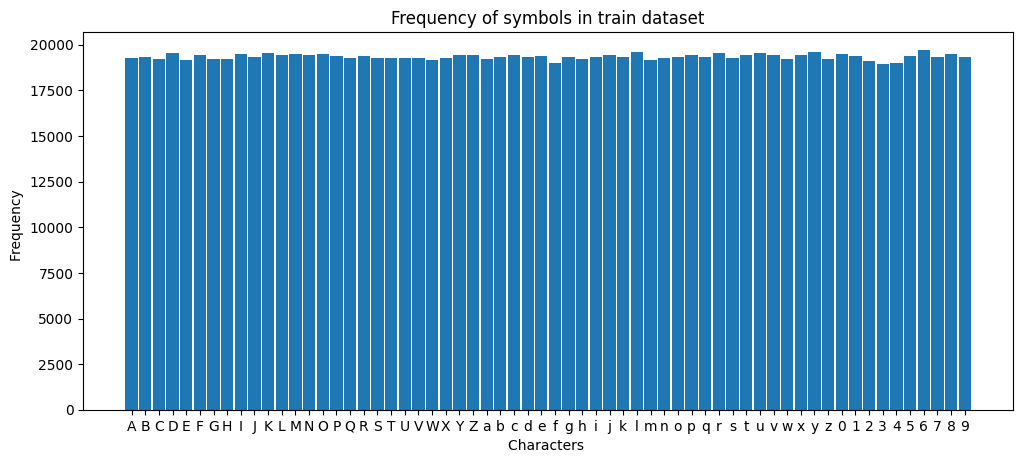

In [8]:
plt.figure(num=None, figsize=(12, 5), dpi=100, facecolor='w', edgecolor='k')
plt.bar(index.keys(), index.values(), width=0.9)
plt.title('Frequency of symbols in train dataset')
plt.xlabel("Characters ", fontsize=10)  
plt.ylabel("Frequency  ", fontsize=10)
plt.show()

In [9]:
# Creating dataloaders - to do: add labels to dataloaders

workers = 2                           # worker threads for loading the data with the DataLoader
batch_size = 128
image_size = [60, 180]
nc = 3                                # number of color channels in the input images
num_epochs = 10
lr = 0.0002                           # learning rate for training
beta1 = 0.5                           # hyperparameter for Adam optimizers
manualSeed = 999                      # for reproducibility
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [10]:
# Create train dataset
dataset_train = dset.ImageFolder(
                    root='/content/train',
                    transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


In [11]:
# Create test dataset
dataset_test = dset.ImageFolder(
                    root='/content/test',
                    transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [12]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

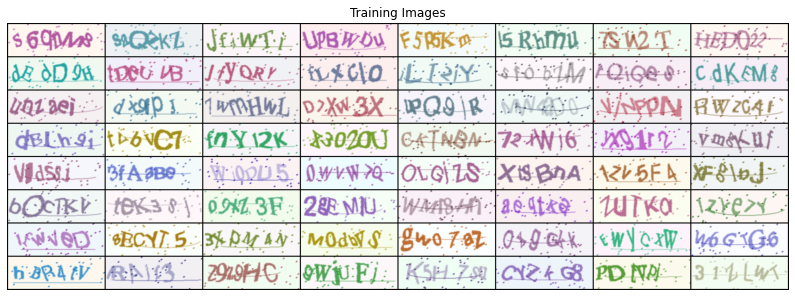

In [13]:
# view some train images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

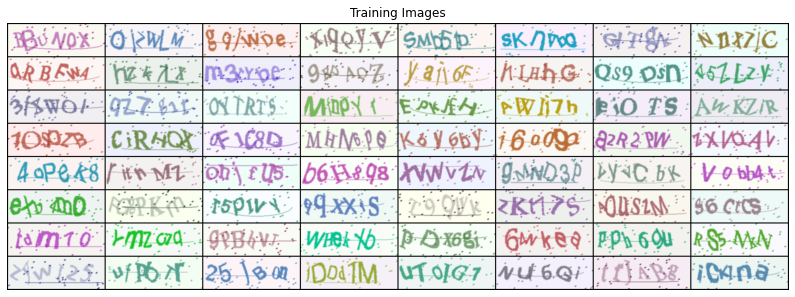

In [14]:
# view some test images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Creating model